# Vendas Futuras

O notebook a seguir descreve os estudos e os passos levados para realizar a competição [Predict Future Sales no kaggle](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview) que procura predizer as futuras vendas de uma rede de lojas. O notebook a seguir explica os passos levados para uma aplicação dos regressores Random Forest e XGBoost na análise do problema.

Este notebook foi construindo utilizando diversas referências que podem ser encontradas nos links a seguir:

1. https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/
2. https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
3. https://mlwhiz.com/blog/2017/12/26/win_a_data_science_competition/
4. https://www.kaggle.com/alessandrosolbiati/using-xgboost-for-time-series-prediction-top-20
5. https://www.kaggle.com/josemarrugo/predictionsales

## Análise dos dados

Antes de tudo, é interessante analisarmos com o que estamos trabalhando, a base e o objetivo dela. A base é composta de vendas realizadas ao longo de 34 meses, cada elemento da base representa uma venda, com informações como identificador do item, identificador da loja onde foi vendido, preço, quantidade de produtos, a categoria do produto, entre outras informações. O propósito desta competição é, a partir dos dados ao longo dos 34 meses, prever vendas do 35º mês. Com as informações disponíveis é possível tentar entender um possível padrão de vendas que generalize bem o cenário e usá-lo para prever as vendas futuras. Os dados da competição são distribuídos em 6 partes:

* **shops**: contém o nome de cada loja e seu id;

* **items**: contém o nome de cada item, seu id, e a qual categoria ele pertence;

* **item_categories**: contém as categorias dos itens;

* **sales_train**: contém os dados das vendas, possui o id do item, o id da loja na qual a venda foi realizada, o dia e o mês da venda, o preço do item e a quantidade de itens vendidos;

* **sample_submission**: um exemplo de submissão;

* **test**: contém o id da loja e do item no qual se deseja prever a venda no 35º mês.

Algumas informações não fazem muita diferença na análise, como o nome do produto e da loja, já que eles possuem id's que servem para identificá-los.

Começamos importando algumas bibliotecas utilizadas na análise, como a [pandas](https://pandas.pydata.org/docs/reference/index.html), o [numpy](https://numpy.org/doc/stable/reference/index.html) e o [matplotlib](https://matplotlib.org/). Depois, abrimos os arquivos com os dados das vendas.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def open_csv(file):
    path = '/kaggle/input/competitive-data-science-predict-future-sales'
    return pd.read_csv(os.path.join(path, file))

# Abre os arquivos
items = open_csv('items.csv')
shops = open_csv('shops.csv')
item_categories = open_csv('item_categories.csv')
train = open_csv('sales_train.csv')
submission = open_csv('sample_submission.csv')
test = open_csv('test.csv')

Abaixo podemos visualizar a quantidade de registros e o tamanho dos dataframes:

In [3]:
print(f'Número de elementos no dataframe de treino: {train.shape[0]}')
print(f'Quantidade de lojas diferentes: {shops.shape[0]}')
print(f'Quantidade de itens diferentes: {items.shape[0]}')
print(f'Quantidade de categorias diferentes: {item_categories.shape[0]}')

Número de elementos no dataframe de treino: 2935849
Quantidade de lojas diferentes: 60
Quantidade de itens diferentes: 22170
Quantidade de categorias diferentes: 84


In [4]:
print(train.columns)

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')


O dataframe possui 6 colunas, que são descritas abaixo:
* **date**: data da venda no formato dd/mm/aa;
* **date_block_num**: mês da venda representado em uma variável de 0 até 33;
* **shop_id**: identificador da loja;
* **item_id**: identificador do item;
* **item_price**: preço do item;
* **item_cnt_day**: quantidade de itens vendidos.

## Pré-processamento

Nos próximos blocos, são realizados alguns tratamentos iniciais no dataset. Tiramos features que foram duplicadas na junção de arquivos, dados desnecessários, como nome dos itens. Como o propósito é a predição de um mês inteiro de vendas, os dados serão agrupados por mês utilizando a informação contida na variável **date_block_num**, logo, o dia da venda também não é útil e será retirado do dataframe.

In [5]:
# Remove dados duplicados
attr = ['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']
old_size = train.shape[0]
train.drop_duplicates(attr, inplace=True)
print(f'Quantidade de elementos duplicados: {old_size - train.shape[0]}')

Quantidade de elementos duplicados: 24


In [6]:
# Retira dados sem relevância para a análise
train.drop(columns=['date'], inplace=True)
items.drop(columns=['item_name'], inplace=True)
test.drop(columns=['ID'], inplace=True)

Foram retirados alguns elementos **outliers** do dataframe, que são valores atípicos ou prováveis erros na coleta dos dados. Os valores retirados foram em relação ao preço dos itens, e a quantidade de itens retirados. A partir da análise feita abaixo, foi identificada a existência de valores negativos, que não fazem sentido para essas variáveis, e de valores muito distantes das médias, que foram selecionados a partir de um limite definido olhando para os gráficos.

Vendas:
count    2.935825e+06
mean     1.242643e+00
std      2.618845e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64


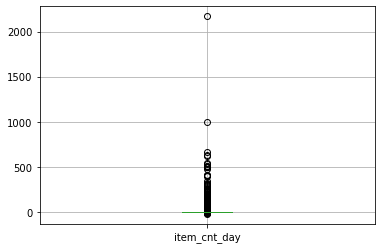


Preço:
count    2.935825e+06
mean     8.908558e+02
std      1.729806e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64


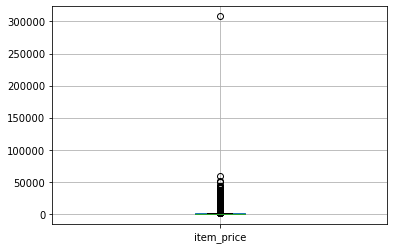

In [7]:
# Retira outliers
old_size = train.shape[0]
print('Vendas:')
print(train['item_cnt_day'].describe())
train.boxplot(column='item_cnt_day')
plt.show()
print('\nPreço:')
print(train['item_price'].describe())
train.boxplot(column='item_price')
plt.show()

In [8]:
train = train[(train['item_cnt_day'] >= 0) &
              (train['item_cnt_day'] <= 800) &
              (train['item_price'] >= 0) &
              (train['item_price'] <= 100000)]

print(f'Quantidade de elementos retirados: {old_size - train.shape[0]}')

Quantidade de elementos retirados: 7360


Uma variável interessante de ser utilizada na análise é a **categoria** dos itens, pois agrupa os produtos em relação a suas características, que podem ter alguma relação as vendas. Esse atributo foi adicionado utilizando a função [**merge**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) do pandas.

In [9]:
# Adiciona a categoria dos itens ao dataframe
train = pd.merge(train, items, on='item_id', how='left')
test = pd.merge(test, items, on='item_id', how='left')

Manipular dataframes com grandes quantidades de informação (quase 3 milhões de elementos no dataframe de treino) pode ser um problema, pois torna o pré-processamento e o processamento computacionalmente custosos, necessitando de uma grande quantidade de memória para manipular os dados. Para amenizar esse problema, utilizaremos de uma função de redução de memória no dataframe principal, que procura armazenar os dados numéricos em variáveis com menos precisão, mas que ocupam menos espaço em memória. A função pode ser vista abaixo e encontrada neste [link](https://www.kaggle.com/gemartin/load-data-reduce-memory-usage), de onde foi retirada.

In [10]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memória utilizada pelo dataframe: {:.2f} MB.'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memória utilizada após a otimização: {:.2f} MB.'.format(end_mem))
    print('Uso de memória reduzido em {:.1f}%.'.format(100 * (start_mem - end_mem) / start_mem))

    return df

Após as modificações feitas, utilizamos a função de redução de memória no dataframe para otimizar os próximos processos.

In [11]:
# Reduz a memória utilizada
train = reduce_mem_usage(train)

Memória utilizada pelo dataframe: 156.40 MB.
Memória utilizada após a otimização: 47.48 MB.
Uso de memória reduzido em 69.6%.


O dataframe utilizado descreve ocorrências de vendas, mas não a ausência delas, não se tem a informação de quando ocorreram zero vendas para certos itens em certas lojas, e sem essa informação o regressor ficará enviesado por apenas possuir informações de quando as vendas ocorrem, assumindo que pelo menos um item será vendido em todas as predições, mesmo sendo possível que nenhum item seja vendido naquele dia.

Para resolver esse problema, precisamos gerar esses dados de quando não existem vendas, que são muitos, pois precisamos inserir zeros para cada combinação de item e loja que não possui informação de venda. Abaixo temos a criação desses novos dados, primeiro iniciamos a variável **grid** e nela geramos todas essas combinações de itens e lojas para um certo mês, para isso utilizamos o método [**unique**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.unique.html) para identificar os valores únicos de item e loja, depois da utilizamos da função [**product**](https://docs.python.org/2/library/itertools.html) para gerar as combinações. Por fim, utilizamos a função [**vstack**](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html) para gerar um dataframe novo, onde as combinações por mês estão empilhadas.

In [12]:
from itertools import product

index_cols = ['shop_id', 'item_id', 'date_block_num']
# Cria uma combinação de cada loja/item daquele mês.
grid = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns=index_cols, dtype=np.int32)

print(f'\nQuantidade de elementos: {grid.shape[0]}\n')

print(grid)


Quantidade de elementos: 10884508

          shop_id  item_id  date_block_num
0              59    22154               0
1              59     2552               0
2              59     2554               0
3              59     2555               0
4              59     2564               0
...           ...      ...             ...
10884503       21     7635              33
10884504       21     7638              33
10884505       21     7640              33
10884506       21     7632              33
10884507       21     7440              33

[10884508 rows x 3 columns]


In [13]:
# Reduz a memória utilizada
grid = reduce_mem_usage(grid)

Memória utilizada pelo dataframe: 124.56 MB.
Memória utilizada após a otimização: 41.52 MB.
Uso de memória reduzido em 66.7%.


Uma vez que o algoritmo possui o intuito de prever vendas de um mês inteiro, e os dados que são fornecidos são de vendas diárias, optamos por agrupar esses dados por mês e não utilizar a informação do dia exato da venda. Essa abordagem é menos custosa computacionalmente, pois diminui a quantidade de dados ao agrupá-los, e é uma abordagem que faz sentido pensando no objetivo final da competição, que é predizer vendas em todo um mês. Para isso utilizamos a função [**groupby**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) para agrupar as vendas de meses iguais, somando as vendas, tirando a média dos preços e armazenando essa nova informação no dataframe **sales_m**.

In [14]:
sales_m = train.groupby(index_cols).agg({'item_cnt_day': 'sum',
                                         'item_price': np.mean}).reset_index()

print(sales_m)

         shop_id  item_id  date_block_num  item_cnt_day  item_price
0              0       30               1          31.0       265.0
1              0       31               1          11.0       434.0
2              0       32               0           6.0       221.0
3              0       32               1          10.0       221.0
4              0       33               0           3.0       347.0
...          ...      ...             ...           ...         ...
1608219       59    22164              27           2.0       699.0
1608220       59    22164              30           1.0       699.0
1608221       59    22167               9           1.0       299.0
1608222       59    22167              11           2.0       299.0
1608223       59    22167              17           1.0       299.0

[1608224 rows x 5 columns]


Depois, utilizamos a função **merge** para unir as novas combinações de item/loja da variável **grid** no novo dataframe **sales_m**, e preenchemos eles com zeros.

In [15]:
sales_m = pd.merge(grid, sales_m, on=index_cols, how='left').fillna(0)

print(f'Quantidade de elementos: {sales_m.shape[0]}\n')
print(sales_m)

Quantidade de elementos: 10884508

          shop_id  item_id  date_block_num  item_cnt_day  item_price
0              59    22154               0           1.0       999.0
1              59     2552               0           0.0         0.0
2              59     2554               0           0.0         0.0
3              59     2555               0           0.0         0.0
4              59     2564               0           0.0         0.0
...           ...      ...             ...           ...         ...
10884503       21     7635              33           0.0         0.0
10884504       21     7638              33           0.0         0.0
10884505       21     7640              33           0.0         0.0
10884506       21     7632              33           0.0         0.0
10884507       21     7440              33           0.0         0.0

[10884508 rows x 5 columns]


Adicionamos também no novo dataframe as categorias dos itens.

In [16]:
sales_m = pd.merge(sales_m, items, on='item_id', how='left')

## Novos atributos

Agora, criamos novos atributos de média e soma da quantidade de itens e de média do preço, isso para cada item, loja e categoria diferente. Essa abordagem permite que o algoritmo receba informações mais gerais a respeito dos preços e do número de vendas dos itens, das lojas e das categorias, fazendo que o programa consiga analisar a situação das vendas recentes analisando se um produto ou loja ficou ou saiu de tendência.

In [17]:
for type_id in ['item_id', 'shop_id', 'item_category_id']:
    for column_id, aggregator, aggtype in [('item_price', np.mean, 'avg'),
                                           ('item_cnt_day', np.sum, 'sum'),
                                           ('item_cnt_day', np.mean, 'avg')]:

        # Gera os novos atributos e renomeia as colunas
        mean_df = train.groupby([type_id, 'date_block_num']).aggregate(aggregator).reset_index()[[column_id, type_id, 'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id, type_id, 'date_block_num']
        
        # Une os novos atributos ao dataframe original
        sales_m = pd.merge(sales_m, mean_df, on=['date_block_num', type_id], how='left')
    
print(sales_m.columns)

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_day', 'item_price',
       'item_category_id', 'item_id_avg_item_price',
       'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day',
       'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day',
       'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_avg_item_cnt_day'],
      dtype='object')


### Lag features

As **lag features** são abordagens muito utilizadas em problemas de predição temporal, pois os transforma em problemas supervisionados. A ideia é tentar prever valores em um tempo **t** dadas as informações dos tempos **t-1**, **t-2**, ... Essas informações auxiliam o algoritmo a prever vendas em um certo mês utilizando informações de vendas nos meses passados.
Para gerar as lag features, criamos novos atributos temporais com informações de meses passados para cada um dos elementos, a partir de uma janela temporal que define quais meses anteriores serão analisados. A janela analisa os 6 últimos meses antes da predição, e este mesmo mês no ano passado.
Caso queira mais informações sobre lag features [clique aqui]( https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/).
Abaixo temos a implementação de uma função que gera as lag features no dataframe.

In [18]:
# Definimos quais variáveis serão analisadas dos meses passados
lag_variables = list(sales_m.columns[6:])+['item_cnt_day']
# Definimos a janela temporal
lags = [1, 2, 3, 4, 5, 6, 12]
    
def lag_features(df, sales_m):
    for lag in lags:
        # Cria-se uma cópia do sales_m
        sales_new_df = sales_m.copy()
        # Translada os meses adicionando o valor lag a eles
        sales_new_df.date_block_num += lag
        # Adiciona as novas colunas com as variáveis temporais
        sales_new_df = sales_new_df[index_cols+lag_variables]
        sales_new_df.columns = index_cols + [f'{lag_feat}_lag_{lag}'
                                             for lag_feat in lag_variables]
        # Une o dataset original com o com os atributos temporais, usando de referência
        # o identificador do item e da loja, e o mês de venda (index_cols).
        df = pd.merge(df, sales_new_df, on=index_cols, how='left')

    return df


lag_train = sales_m.copy()
lag_train = lag_features(lag_train, sales_m)

print(f'Quantidade de atributos no dataframe: {lag_train.shape[1]}\n')
print(lag_train.columns)

Quantidade de atributos no dataframe: 85

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_day', 'item_price',
       'item_category_id', 'item_id_avg_item_price',
       'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day',
       'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day',
       'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_avg_item_cnt_day', 'item_id_avg_item_price_lag_1',
       'item_id_sum_item_cnt_day_lag_1', 'item_id_avg_item_cnt_day_lag_1',
       'shop_id_avg_item_price_lag_1', 'shop_id_sum_item_cnt_day_lag_1',
       'shop_id_avg_item_cnt_day_lag_1',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_sum_item_cnt_day_lag_1',
       'item_category_id_avg_item_cnt_day_lag_1', 'item_cnt_day_lag_1',
       'item_id_avg_item_price_lag_2', 'item_id_sum_item_cnt_day_lag_2',
       'item_id_avg_item_cnt_day_lag_2', 'shop_id_avg_item_price_lag_2',
       's

Com os novos atributos temporais prontos, precisamos preencher os valores ausentes, abaixo a função **fillNaN** trocamos todos os valores NaN gerados acima por zero quando se trata da quantidade de itens vendidas já que quando não há informação indica que nada foi vendido daquele item na loja, ou pela mediana quando se trata dos preços já que durante um único mês pode existir a variação dos preços dos itens, e foi decidido colocar a mediana para representar o valor durante o mês inteiro.

In [19]:
def fillNaN(df):
    for feat in df.columns:
        if 'item_cnt' in feat:
            df[feat] = df[feat].fillna(0)
        elif 'item_price' in feat:
            df[feat] = df[feat].fillna(df[feat].median())

fillNaN(lag_train)

Por utilizar a abordagem das lag features, os primeiros doze meses do dataframe não possuem as informações necessárias para gerar todas as variáveis temporais, por isso eles são retirados do dataframe. Depois, para lidar melhor com a [sazonalidade]( https://www.devmedia.com.br/data-mining-na-pratica-time-series/5414) anual de venda dos produtos, utilizamos a abordagem de gerar dois novos atributos, um de ano, com um valor entre 0 e 2, e outro de mês, com um valor entre 0 e 11, dessa forma é possível isolar características que dizem respeito a certos períodos do ano.

In [20]:
def date_attr(df):
    df['month'] = df['date_block_num'] % 12
    df['year'] = df['date_block_num'] // 12
    df.drop(columns='date_block_num', inplace=True)
    return df

# Retira os meses do primeiro ano
lag_train = lag_train[lag_train['date_block_num'] > 12]
# Gera novos atributos de ano e mês
lag_train = date_attr(lag_train)

In [21]:
# Retira os atributos que não serão utilizados na análise,
# como os atributos utilizados para gerar as lag features.
cols_to_drop = lag_variables[:-1] + ['item_price']
lag_train.drop(columns=cols_to_drop, inplace=True)

# Reduz a memória utilizada
lag_train = reduce_mem_usage(lag_train)

Memória utilizada pelo dataframe: 941.79 MB.
Memória utilizada após a otimização: 901.35 MB.
Uso de memória reduzido em 4.3%.


Com o dataset de treino completo, precisamos inserir essas variáveis temporais nos testes, já que apenas possuímos a informação de qual item em qual loja desejamos prever. Para isso, inicializamos a data como o 35º mês (valor 34), e utilizamos das mesmas funções implementadas ao gerar os casos de treino para gerar as lag_features, preencher os dados vazios gerados e adicionar os novos dois atributos de mês e ano.

In [22]:
test['date_block_num'] = 34

test = lag_features(test, sales_m)
fillNaN(test)
test = date_attr(test)

O dataframe **lag_train** possui as informações para o treino do regressor, todos os atributos preditivos mais a coluna **item_cnt_day**, que representa o número de vendas, informação que se deseja prever com esses testes.

O dataframe **test** possui os mesmos atributos preditivos que o dataframe de treino, com informações do 35º mês, porém sem a coluna **item_cnt_day** que é o que se deseja prever.

Um teste abaixo foi feito para confirmar que os dataframes possuem a mesma estrutura.

In [23]:
# Verificando se o treino e o teste possuem as mesmas colunas
_test = set(test.columns)
_train = set(lag_train.drop(columns='item_cnt_day').columns)
assert _test==_train

## Processamento

Após o pré-processamento feito no dataframe, ele está pronto para ser utilizado pelos algoritmos regressores. Aqui testaremos com dois deles, o [Random Forest]( https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) e o [XGBoost]( https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=matrix#xgboost.DMatrix), para que seja possível analisarmos a diferença dos resultados obtidos utilizando dois algoritmos diferentes.

### Random Forest

Após todas as análises feitas, e todo tratamento com a base, estamos enfim prontos para processar e estabelecer nossas predições. Abaixo temos a finalização do projeto, aqui inicialmente usamos uma regressão com floresta aleatória criando 10 árvores, com n_jobs = -1, para usar todas as unidades centrais de processamento, já que a base, mesmo com funções para diminuir o custo de memória ainda é muito pesado foi necessário reduzir o número de árvores para dez o que pelos testes feitos não afetaram tanto na precisão da predição. Treinamos a floresta com a base trabalhada, e transformamos o exemplo de submissão da base na nossa predição. Além disso devemos para a submissão devemos limitar as vendas da predição de 0 a 20 para enfim transformar em um arquivo csv e submeter.

In [24]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=10, n_jobs = -1)

regressor.fit(lag_train.drop(columns=['item_cnt_day']),
              lag_train['item_cnt_day'])

pred = regressor.predict(test)

pred = pred.clip(0, 20)


submission['item_cnt_month'] = pred

submission.to_csv('submission_rf.csv', index=False)

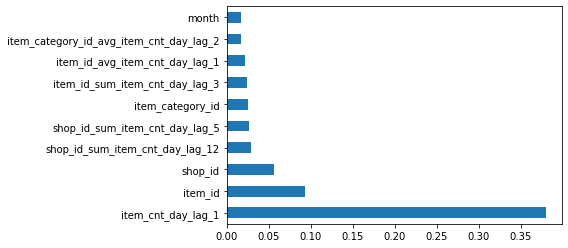

In [25]:
# Feature importance
feat_importances = pd.Series(regressor.feature_importances_, index=lag_train.drop(columns=['item_cnt_day']).columns)
feat_importances.nlargest(10).plot(kind='barh')

Como pode-se ver acima foi mostrado o gráfico com a feature importances que indica quais atributos mais influenciaram na predição, nesse caso o programa definiu que a informações mais importantes são a venda do mês passado, o item que está sendo vendido e a loja onde ele está sendo vendido, o que são resultados bem interessantes ao pensar que a venda do mês passado seja a informação mais importante por ser a mais recente.

A abordagem utilizando Random Forest alcançou um erro de 1.10

### XGBoost

Depois de tratar os dados da predição, agora sim podemos processá-la. Primeiro é claro treinamos com os meses passados o xgboost com os parâmetros abaixo. Depois fazemos a predição de vendas do xgboost, e criamos o arquivo padrão para envio.

Os parâmetros foram escolhidos em sua maioria a partir da análise do dataset feito em outros notebooks da competição principalmente [esse]( https://www.kaggle.com/alessandrosolbiati/using-xgboost-for-time-series-prediction-top-20
), alguns foram testes que nós mesmos fizemos, que envolve em sua maioria reduzir o uso de memória. O parâmetro **max_depth** foi definido em 10 para dar uma maior liberdade de crescimento do programa que o valor default de 6, foi decidido colocar a **verbosity** em 0 para deixar o output mais limpo, e **eval_metric** foi decidido como forma de auto avaliação do algoritmo para aprendizado ser igual à da competição, para os outros parâmetros foi decidido manter o valor default do programa depois dos testes darem bons resultados.

In [26]:
param = {'max_depth': 10,
         'subsample': 1,
         'min_child_weight': 1,
         'eta': 0.3,
         'num_round': 1000,
         'eval_metric': 'rmse',
         'verbosity': 0}

In [27]:
import xgboost as xgb

xgbtrain = xgb.DMatrix(lag_train.drop(columns=['item_cnt_day']),
                       lag_train['item_cnt_day'])

bst = xgb.train(param, xgbtrain)

xgbpredict = xgb.DMatrix(test)
pred = bst.predict(xgbpredict)
pred = pred.clip(0, 20)

submission['item_cnt_month'] = pred

submission.to_csv('submission_xgboost.csv', index=False)

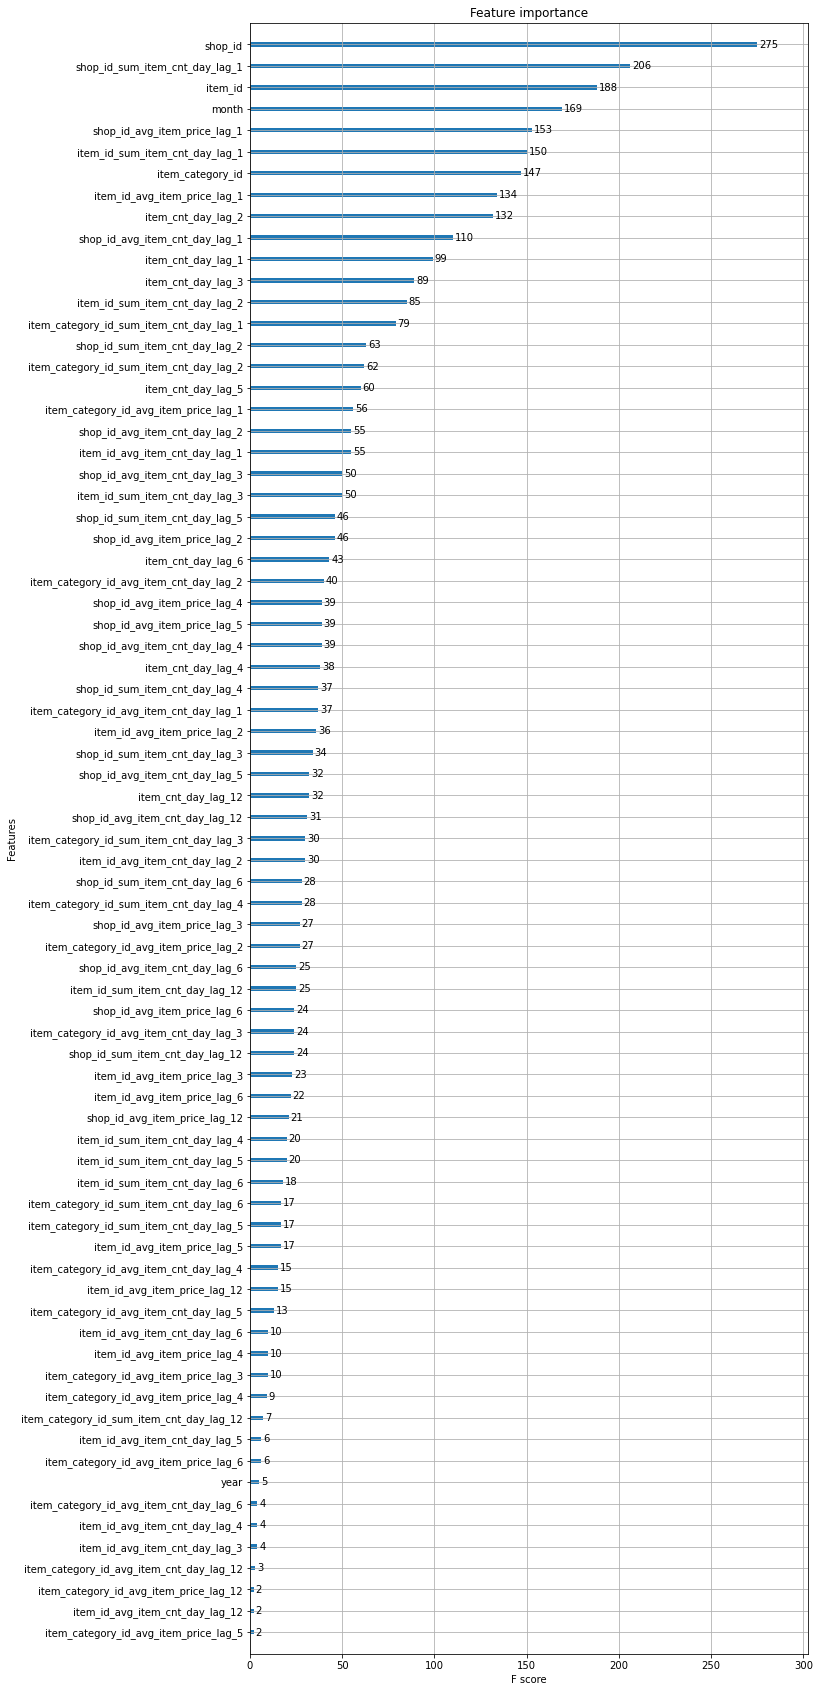

In [28]:
# Feature importance
x = xgb.plot_importance(bst)
x.figure.set_size_inches(10, 30)

Aqui o algoritmo percebe uma importância muito grande para qual loja estamos falando, seguida das vendas do mês passado, o item sendo analisado, o mês do ano em que estamos, e a média de preços dos itens vendidos no mês passado. A enorme importância das lojas é intuitiva, já que existem lojas que nunca vendem nada. O item também faz sentido, já que produtos são naturalmente mais vendidos e necessários que outros.

Mas o interessante a se notar aqui é talvez, a diferença entre as importâncias de atributos dado por ambos os modelos. Que se difere em muitos pontos, mas outros são idênticos, talvez seja esse o motivo pelo qual o resultado foi diferente, e mostram também a maior precisão do xgboost para o dataset final.

A abordagem utilizando XGBoost alcançou um erro de 0.93, e garantindo a posição 2603º no rank da competição no dia 30/06/2020.

## Conclusão

A abordagem utilizando lag features foi eficaz e trouxe resultados consideráveis, alcançamos um erro rmse de 0.93 utilizando xgboost, que demora por volta de 30 minutos para treinar e predizer as vendas, e um erro rmse de 1.10 utilizando a random forest, que não conseguiu resultados tão bons quanto o xgboost e levava por volta de 1 hora para treinar e predizer as vendas. Ambas as abordagens alcançaram resultados melhores que os valores iniciais do arquivo de submissão, que chuta todas as predições como 0.5, que alcançou 1.23 de erro.

## Evolução do programa
Durante a criação desse notebook foram criadas várias abordagens do problema, que ao longo do tempo foram naturalmente evoluindo. Abaixo descrevemos como essa evolução se deu. 

### versão 0

Primeiramente nós começamos apenas colocando o data set no programa para ver os resultados, para assim entendermos melhor as notas da competição. Nos deparamos então com o primeiro problema do dataset, ele vinha com os dados de dias e o target era um mês inteiro, felizmente esse foi um problema que foi facilmente resolvido por juntar as informações dos dias do mês apenas no mês.

### versão 1

O que nos levou ao segundo problema pelo formato do dataset, nós só temos dados de quando houveram vendas. Isso foi um grande obstáculo pois isso indica para o algoritmo, que nós sempre temos vendas o que é muito ruim para análise, já que a maioria das vezes não existem vendas. Então nós pegamos uma solução simples para esse problema, inserir os zeros manualmente, porém isso  veio com um custo, um alto consumo de memória que se não parasse o algoritmo em fase de manipular os dados, o programa morria no treino.

### versão 2

Após isso criamos outra abordagem a de utilizar as categorias, que dessa forma o programa poderia adicionar os zeros e ainda treinar de uma forma tranquila. Porém apesar de ter um resultado melhor que o primeiro por uma grande margem e funcionar diferentemente da segunda abordagem, nós não estamos satisfeitos com simplesmente analisar os itens por categoria e dar resultados iguais a todos os itens, de uma categoria, já que isso é de certa forma contraproducente, já que é mais uma super generalização do comportamento do que uma solução de fato. Então nós fomos a terceira abordagem e o início da implementação de xgboost.

### versão 3

Diferentemente das outras abordagens nós tentamos ver o problema em uma visão temporal onde cada mês anterior se torna um atributo para o próximo e esse se torna o target. Essa foi por muito tempo nosso melhor resultado em xgboost porém ele não se mostrou tão efetivo quanto o método anterior para Random Forest levando o grupo a tentar diferente.

### versão 4

Nesse momento nós tentamos dar uma olhada de volta na abordagem 2 para tentarmos melhora-la e encontramos a [reduce_mem_usage]( https://www.kaggle.com/gemartin/load-data-reduce-memory-usage) uma função muito útil que utiliza da redução de variável para reduzir o consumo de memoria. Tal função resultou em uma redução de quase 80% do uso de memória deixando a abordagem 1 viável novamente e com isso tivemos um resultado melhor.

### versão 5

Aqui percebemos que ambas as abordagens que testamos se tornaram possíveis, e obtiveram bons resultados. Separadamente. Então tentamos ver se ambos juntas poderiam melhorar o nosso resultado. A ideia era utilizar as categorias e a redução de memória para colocar todos os 0. Mas a suposição se mostrou errada, o resultado se tornou pior que ambos separados. Provavelmente o algoritmo se enviesa nessa união, além de ter se tornado mais custoso.

### versão 6

Por fim resolvemos tentar implementar novamente o viés temporal no algoritmo, essa versão é versão do notebook acima, com os resultados muito melhores do que os anteriores, tanto para Random Forest, quanto para Xgboost. Nesta versão usamos também partes das versões anteriores para melhorar a predição com aspectos chave de cada uma.